--- Starting Model Training & Evaluation Workflow ---
Loading training data from: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/train.csv
Training data loaded successfully.

--- 2. Data Exploration ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  


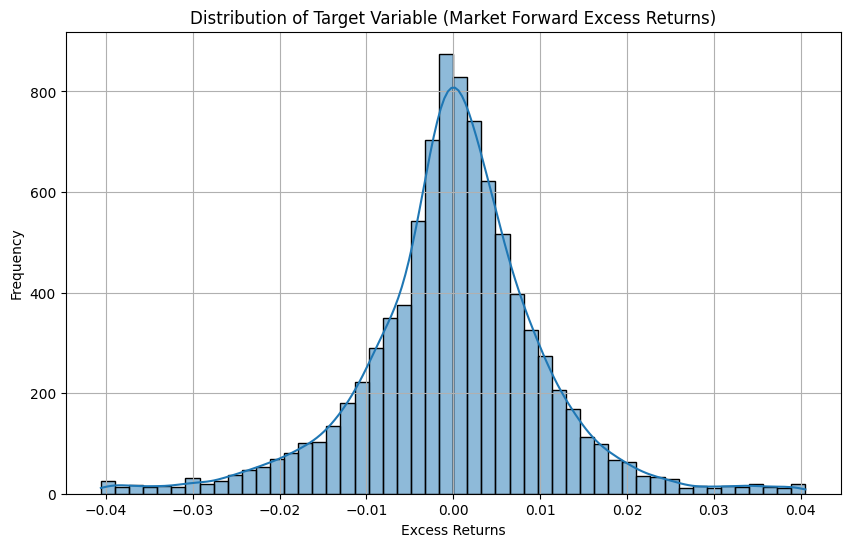


--- 3. Feature Selection & Preprocessing ---


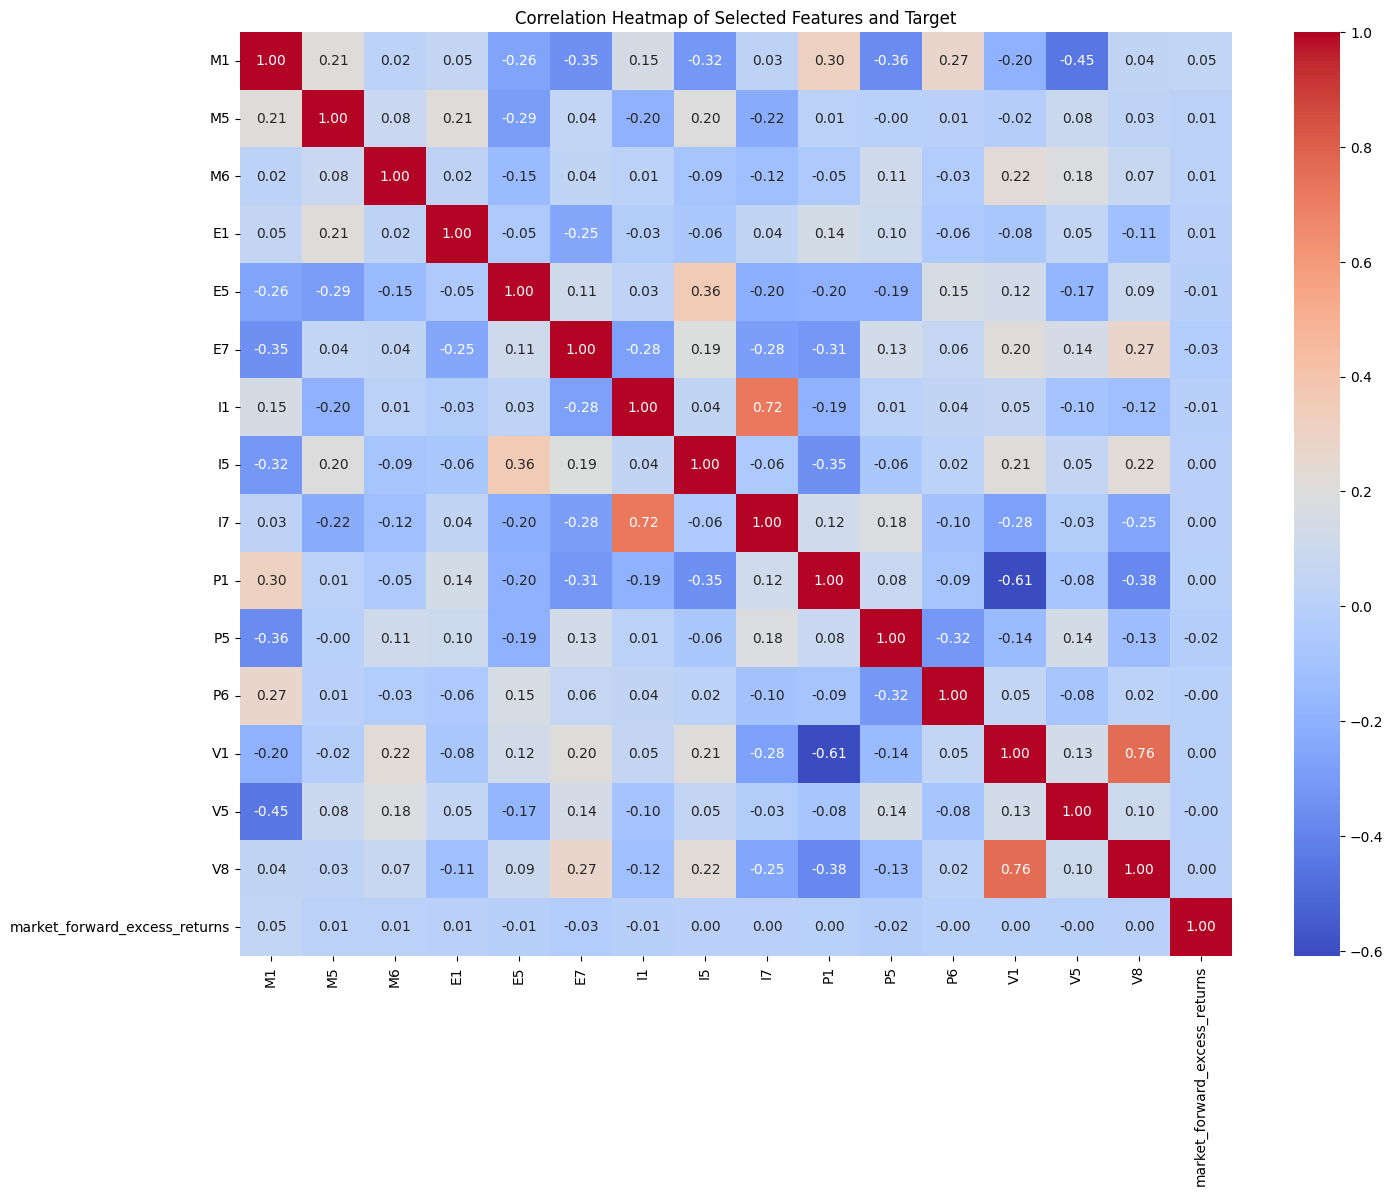

Training data shape: (7192, 23)
Validation data shape: (1798, 23)

--- 5. Model Training with Evaluation ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4883
[LightGBM] [Info] Number of data points in the train set: 7192, number of used features: 23
[LightGBM] [Info] Start training from score 0.000014
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0101064	training's l2: 0.000102139	valid_1's rmse: 0.0111223	valid_1's l2: 0.000123706
Early stopping, best iteration is:
[39]	training's rmse: 0.010295	training's l2: 0.000105987	valid_1's rmse: 0.011094	valid_1's l2: 0.000123076

--- 6. Model Analysis ---


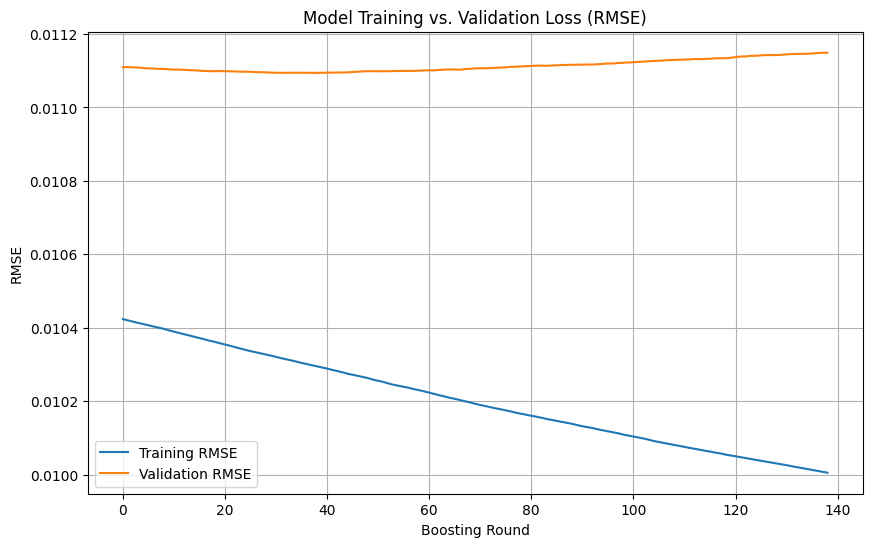

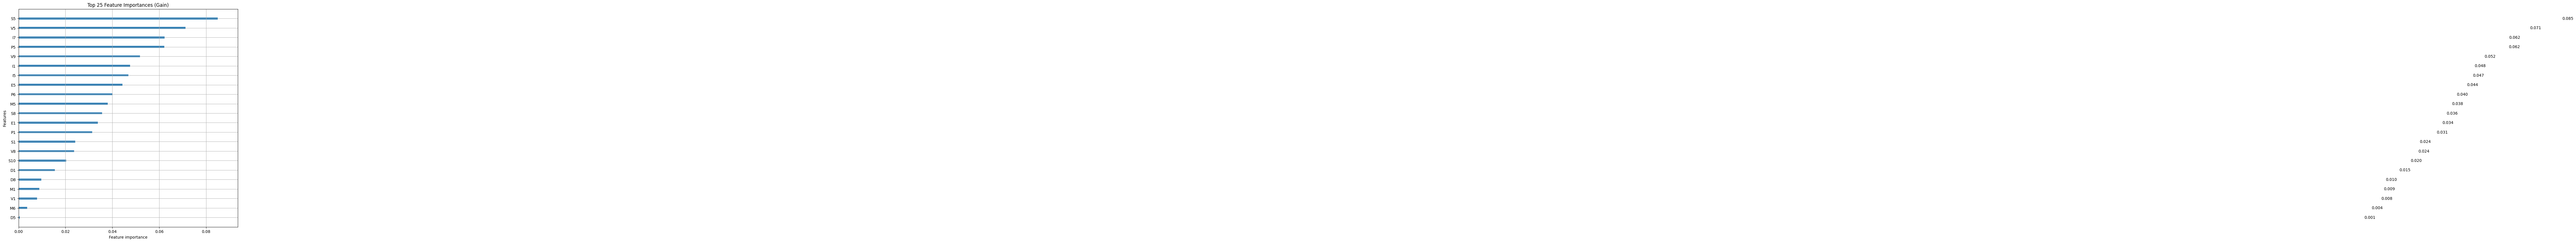


--- 7. Training Final Model on All Data ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 23
[LightGBM] [Info] Start training from score 0.000051
Final model training complete.
Saving final model to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/lgbm_model.pkl
Model saved successfully.
Saving feature list to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/selected_features.txt
Feature list saved successfully.

--- Workflow Finished Successfully! ---


In [4]:
import pandas as pd
import lightgbm as lgb
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- Configuration ---
# IMPORTANT: Make sure these paths are correct for your local setup.
DATA_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'
OUTPUT_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'

TRAIN_FILE_PATH = os.path.join(DATA_PATH, 'train.csv')
MODEL_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'lgbm_model.pkl')
FEATURES_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'selected_features.txt')

def train_and_evaluate_model():
    """
    A comprehensive workflow to load data, explore it, train a LightGBM model,
    evaluate its performance, and save the final artifacts.
    """
    print("--- Starting Model Training & Evaluation Workflow ---")

    # --- 1. Load Data ---
    try:
        print(f"Loading training data from: {TRAIN_FILE_PATH}")
        df_train = pd.read_csv(TRAIN_FILE_PATH)
        print("Training data loaded successfully.")
    except FileNotFoundError:
        print(f"ERROR: Training file not found at {TRAIN_FILE_PATH}")
        return

    # --- 2. Data Exploration & Examination ---
    print("\n--- 2. Data Exploration ---")
    print("DataFrame Info:")
    df_train.info()
    print("\nDataFrame Head:")
    print(df_train.head())
    print("\nSummary Statistics:")
    print(df_train.describe())
    
    # Plotting the distribution of the target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df_train['market_forward_excess_returns'].dropna(), kde=True, bins=50)
    plt.title('Distribution of Target Variable (Market Forward Excess Returns)')
    plt.xlabel('Excess Returns')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # --- 3. Feature Selection & Preprocessing ---
    print("\n--- 3. Feature Selection & Preprocessing ---")
    selected_features = [
        'M1', 'M5', 'M6', 'E1', 'E5', 'E7', 'I1', 'I5', 'I7',
        'P1', 'P5', 'P6', 'V1', 'V5', 'V8', 'V9',
        'S1', 'S5', 'S8', 'S10', 
        'D1', 'D5', 'D8'
    ]
    target = 'market_forward_excess_returns'
    
    # Create a smaller correlation matrix for visualization
    corr_features = selected_features[:15] + [target]
    correlation_matrix = df_train[corr_features].corr()
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Selected Features and Target')
    plt.show()
    
    df_train.dropna(subset=[target], inplace=True)
    
    # Forward-fill NaNs, then back-fill any remaining at the start
    X = df_train[selected_features].ffill().bfill()
    y = df_train[target]

    # --- 4. Time-Series Split ---
    # We split the data for validation without shuffling to respect the time-series nature
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # --- 5. Model Training & Evaluation ---
    print("\n--- 5. Model Training with Evaluation ---")
    lgbm = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=2000,          # Increased estimators
        learning_rate=0.01,         # Slower learning rate
        num_leaves=31,
        max_depth=-1,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,              # L1 Regularization
        reg_lambda=1.0              # L2 Regularization (increased)
    )

    lgbm.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)],
             eval_metric='rmse',
             callbacks=[lgb.early_stopping(100, verbose=True), lgb.log_evaluation(100)])

    # --- 6. Analysis & Visualization ---
    print("\n--- 6. Model Analysis ---")
    
    # Plot Training vs. Validation Loss
    results = lgbm.evals_result_
    plt.figure(figsize=(10, 6))
    plt.plot(results['training']['rmse'], label='Training RMSE')
    plt.plot(results['valid_1']['rmse'], label='Validation RMSE')
    plt.title('Model Training vs. Validation Loss (RMSE)')
    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Feature Importance
    lgb.plot_importance(lgbm, max_num_features=25, figsize=(10, 10), importance_type='gain')
    plt.title('Top 25 Feature Importances (Gain)')
    plt.show()

    # --- 7. Final Model Training & Saving ---
    print("\n--- 7. Training Final Model on All Data ---")
    # Now, train the final model on the entire dataset with the found number of iterations
    final_model = lgb.LGBMRegressor(**lgbm.get_params())
    final_model.set_params(n_estimators=lgbm.best_iteration_)
    final_model.fit(X, y)
    print("Final model training complete.")

    # Save the final model
    print(f"Saving final model to: {MODEL_OUTPUT_PATH}")
    with open(MODEL_OUTPUT_PATH, 'wb') as f:
        pickle.dump(final_model, f)
    print("Model saved successfully.")

    # Save the feature list
    print(f"Saving feature list to: {FEATURES_OUTPUT_PATH}")
    with open(FEATURES_OUTPUT_PATH, 'w') as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    print("Feature list saved successfully.")
    print("\n--- Workflow Finished Successfully! ---")


if __name__ == '__main__':
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    train_and_evaluate_model()

